In [57]:
from utils import *

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 12),
            nn.ReLU(),
            #nn.Linear(128,64),
            #nn.ReLU(),
            nn.Linear(12, output_size),  # Output Q-values for each action
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)


In [59]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            torch.tensor(state, dtype=torch.float32), 
            action, 
            reward, 
            torch.tensor(next_state, dtype=torch.float32), 
            done
        ))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


In [60]:
def train_q_learning(params, q_net, target_net, optimizer, replay_buffer, num_episodes=700, batch_size=64, gamma=0.999, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500, episode_length=20, deployment_cost=0.1):
    epsilon = epsilon_start
    epsilon_decay_rate = (epsilon_start - epsilon_end) / epsilon_decay
    target_update_freq = 10
    replay_start_size = 100
    total_rewards = []
    plot_reward_series = []

    for episode in range(num_episodes):
        env = ContinuousEnvironment(params)
        state = torch.tensor([env.current_error], dtype=torch.float32)
        episode_reward = 0
        reward_series = []
        for t in range(episode_length):  # Limit steps per episode
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randint(0, 1)  # Random action
            else:
                with torch.no_grad():
                    q_values = q_net(state)
                    #print(q_values)
                    action = torch.argmax(q_values).item()

            action_str = "collect" if action == 0 else "deploy"
            # print(action_str)
            #prev_utility = env.current_utility

            # Take action in the environment
            env.step(action_str)
            #env.render()
            #next_state = torch.tensor([env.current_utility], dtype=torch.float32)
            next_state = torch.tensor([env.current_error], dtype=torch.float32)
            if action_str == "collect":
                reward = env.current_utility
            else:
                reward = env.current_utility - deployment_cost
            done = t == (episode_length-1)
            reward_series.append(reward)
            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward

            # Train the Q-network if enough samples are in the replay buffer
            if len(replay_buffer) > replay_start_size:
                transitions = replay_buffer.sample(batch_size)
                batch = {
                    "state": torch.stack([k[0] for k in transitions]),
                    "action": torch.tensor([k[1] for k in transitions]),
                    "reward": torch.tensor([k[2] for k in transitions]),
                    "next_state": torch.stack([k[3] for k in transitions]),
                    "done": torch.tensor([k[4] for k in transitions], dtype=torch.float32)
                }

                # Compute Q-targets
                with torch.no_grad():
                    # Compute the target Q-value using the current environment's utility
                    #max_next_q_values = torch.tensor(ccf(env.current_utility, params["max_utility"]), dtype=torch.float32)
                    max_next_q_values = target_net(batch["next_state"]).max(1)[0]
                    # TD Target
                    q_targets = batch["reward"] + gamma * max_next_q_values * (1 - batch["done"])

                    # Predicted Q-value for the taken action
                q_targets = q_targets.float()
                q_values = q_net(batch["state"]).gather(1, batch["action"].unsqueeze(1)).squeeze().float()
                
                # Compute loss (MSE or Huber)
                loss_fn = nn.HuberLoss()  # You can replace this with nn.HuberLoss() for more stability
                loss = loss_fn(q_values, q_targets)

                #if episode % 10 == 0:
                #    print(loss.item())
                # Update Q-network
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Break if terminal state is reached
            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon - epsilon_decay_rate)

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

        total_rewards.append(episode_reward)
        plot_reward_series.append(reward_series)
        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward: {episode_reward:.5f}, Epsilon: {epsilon:.2f}")

    return total_rewards, plot_reward_series

C:\Users\tomsu\AppData\Local\Temp\ipykernel_20776\2525658232.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(state, dtype=torch.float32),
C:\Users\tomsu\AppData\Local\Temp\ipykernel_20776\2525658232.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(next_state, dtype=torch.float32),


Episode 0: Total Reward: 5.09509, Epsilon: 1.00
Episode 10: Total Reward: 4.82802, Epsilon: 0.98
Episode 20: Total Reward: 6.99528, Epsilon: 0.96
Episode 30: Total Reward: 4.33792, Epsilon: 0.94
Episode 40: Total Reward: 8.27203, Epsilon: 0.92
Episode 50: Total Reward: 6.12998, Epsilon: 0.90
Episode 60: Total Reward: 11.16364, Epsilon: 0.88
Episode 70: Total Reward: 8.11024, Epsilon: 0.86
Episode 80: Total Reward: 8.05020, Epsilon: 0.84
Episode 90: Total Reward: 6.50567, Epsilon: 0.82
Episode 100: Total Reward: 7.08013, Epsilon: 0.80
Episode 110: Total Reward: 8.95241, Epsilon: 0.78
Episode 120: Total Reward: 5.19680, Epsilon: 0.76
Episode 130: Total Reward: 4.71035, Epsilon: 0.74
Episode 140: Total Reward: 8.62044, Epsilon: 0.72
Episode 150: Total Reward: 2.38767, Epsilon: 0.70
Episode 160: Total Reward: 5.66524, Epsilon: 0.68
Episode 170: Total Reward: 7.88067, Epsilon: 0.66
Episode 180: Total Reward: 7.41746, Epsilon: 0.64
Episode 190: Total Reward: 10.15427, Epsilon: 0.62
Episode 2

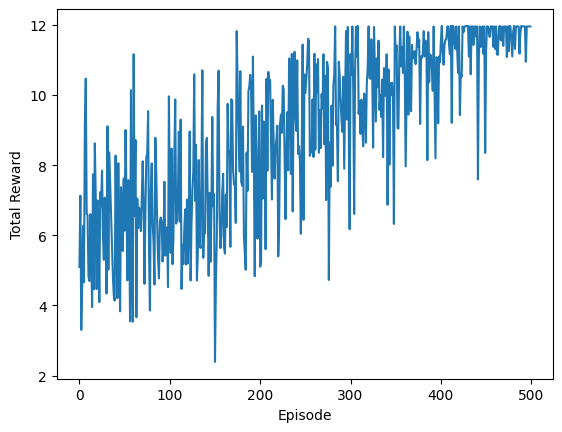

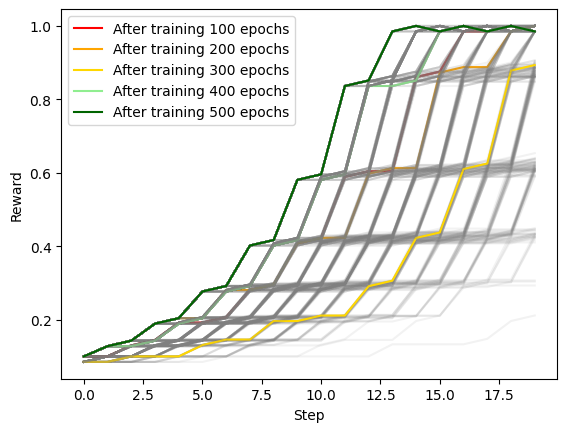

In [62]:
# Initialize environment
params = {
    "start_utility": 0.1,
    "time_preference": 0.95,
    "data_collection_size": 1000,
    "max_utility": 1.0,
}


# Initialize Q-networks and optimizer
q_net = QNetwork(input_size=1, output_size=2)  # 1 state feature, 2 actions
target_net = QNetwork(input_size=1, output_size=2)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=1e-3)

# Initialize replay buffer
replay_buffer = ReplayBuffer(capacity=100000)

# Train the Q-learning agent
rewards, plot_data = train_q_learning(params, q_net, target_net, optimizer, replay_buffer, num_episodes=500, deployment_cost=0.015, epsilon_start=1.0)

# Plot total rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in plot_data:
    counter = counter + 1
    if counter % 100 == 0:
        plt.plot(d, label=f"After training {counter} epochs", color=colors[color])
        color = color +1
    else:
        plt.plot(d, color="gray", alpha=0.1)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()


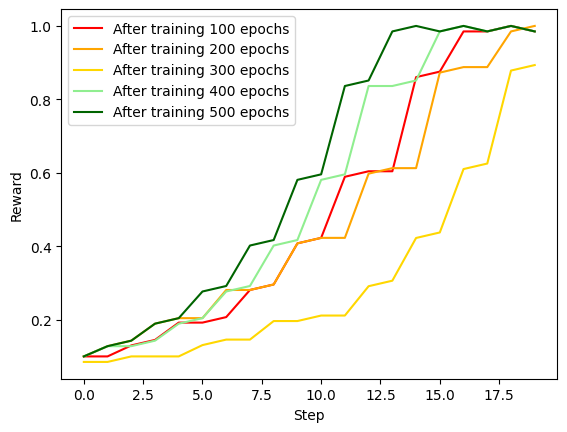

In [63]:
counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in plot_data:
    counter = counter + 1
    if counter % 100 == 0:
        plt.plot(d, label=f"After training {counter} epochs", color=colors[color])
        color = color +1
    #else:
     #   plt.plot(d, color="gray", alpha=0.1)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()


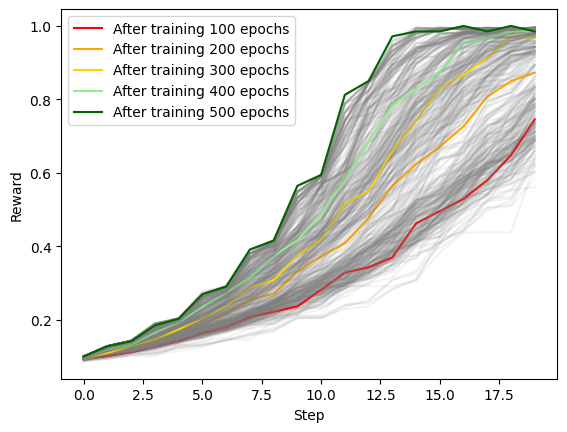

In [71]:
import pandas as pd
df = pd.DataFrame(plot_data)

# Apply rolling window with size 10 and compute the mean
rolling_avg = df.rolling(window=10, min_periods=1).mean()

# Convert back to list of lists if needed
result = rolling_avg.values.tolist()

counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in result:
    counter = counter + 1
    if counter % 100 == 0:
        plt.plot(d, label=f"After training {counter} epochs", color=colors[color])
        color = color +1
    else:
        plt.plot(d, color="gray", alpha=0.1)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [72]:
def calculate_chunk_averages(data, chunk_size=100):
    # Convert to NumPy array for easier operations
    data_array = np.array(data)
    n_chunks = len(data_array) // chunk_size
    
    # Calculate average for each chunk
    chunk_averages = [
        data_array[i * chunk_size : (i + 1) * chunk_size].mean(axis=0)
        for i in range(n_chunks)
    ]
    return chunk_averages

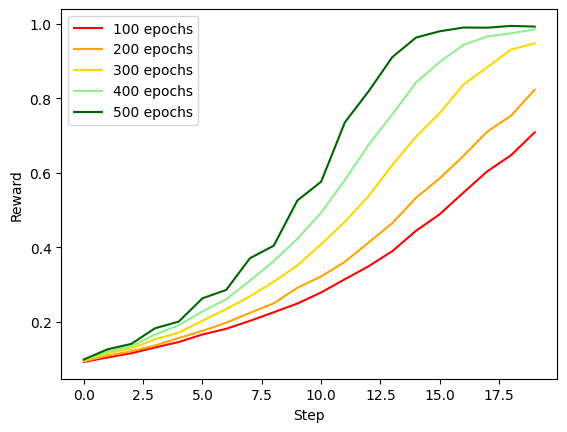

In [73]:
counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
result = calculate_chunk_averages(plot_data)
for d in result:
    counter = counter + 1
    plt.plot(d, label=f"{counter*100} epochs", color=colors[color])
    color = color +1
    #else:
     #   plt.plot(d, color="gray", alpha=0.1)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()
